<a href="https://colab.research.google.com/github/yuriarciniegas/yoaprendo1/blob/master/LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

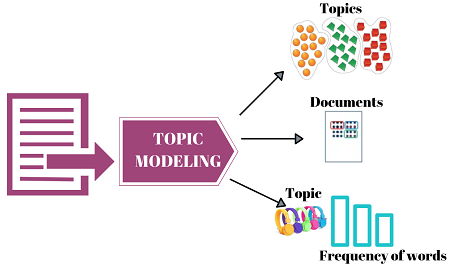

Encuesta cuentanos tu opinion:
https://docs.google.com/forms/d/e/1FAIpQLSfsc3AWBHa_SZuQBa0yq9qX0g73P9Nd4is5e7CQ6MpIRPwB1g/viewform?usp=sf_link

In [ ]:
#Awsome library for LDA Visualization
!pip install pyLDAvis

**Step 1: Read and Organize Data**

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd

#Read data from Google Sheet: experimentos.analitica.datos - CuentanosTuOpinion
df = pd.read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vR0cxs1N4E-1NryBaWPS0dfhZhvs_ogAyVgA3bUfrdKbnOFFpDsAzBOOS3tQqDGFrLeWgvoUC02O0OR/pub?gid=1531549820&single=true&output=tsv", sep="\t")

df.columns = ['Fecha','Opinion']

df.head()


In [ ]:
#Corpus size
df.shape

**Step 2: Define a text preprocessing function**

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from string import punctuation
import unicodedata

nltk.download('stopwords')
stemmer = SnowballStemmer('spanish')
nltk.download('punkt')

stop_words = set(stopwords.words('spanish'))
stop_words = stop_words.union(set(['colombi', 'colombian', 'me', 'le', 'da', 'mi', 'su', 'ha', 'he', 'ya', 'un', 'una', 'es','del', 'las', 'los', 'en', 'que', 'y', 'la','de']))

def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return u"".join([c for c in nfkd_form if not unicodedata.combining(c)])

def fast_preproc(text):
  text = text.lower()
  text = ''.join(c for c in text if not c.isdigit())
  text = ''.join(c for c in text if c not in punctuation)
  text = remove_accents(text)
  words = word_tokenize(text)
  words = [stemmer.stem(word) for word in words]
  words = [word for word in words if not word in stop_words]
  try:
    text = " ".join(str(word) for word in words)
  except Exception as e:
    print(e)
    pass
  return text

print(fast_preproc("áéíóú ÁÉÍÓÚ FRAN Romero; Análisis de Textos. 2022"))

**Step 3: Text preprocessing**

In [ ]:
df['Opinion'] = df['Opinion'].astype(str)

df = df.assign(
    TextPreproc=lambda df: df.Opinion.apply(fast_preproc)
)

df.head()

**Step 4: Data transformation with Count Vectorizer**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer()

#Tokenize and build vocabulary
vec.fit(df['TextPreproc'])
print("\nVocabulary:\n")
print(vec.vocabulary_)

#Encode documents
trans_text_train = vec.transform(df['TextPreproc'])

#Print Document-Term Matrix
df = pd.DataFrame(trans_text_train.toarray(), columns=vec.get_feature_names_out())
df.head()

**Step 5: Latent Dirichelt Allocation**

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation as LDA

def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

number_topics = 8
number_words = 4

# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(trans_text_train)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, vec, number_words)

**Step 6: Awsome LDA visualization**

In [ ]:
import pyLDAvis.lda_model
import pickle
from pickle import Pickler
import pyLDAvis
import os

LDAvis_prepared = pyLDAvis.lda_model.prepare(lda, trans_text_train, vec)

pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(number_topics) +'.html')